Import the required libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import traceback as tb
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

You need to get your Kaggle API token for the next step. How to get your Kaggle API token:
* Open Kaggle and sign in
* Click on your profile picture at top right corner
* Click on "Account"
* Scroll down until you see API section
* Click on "Create New API Token"
* A file named `kaggle.json` will be downloaded.

You need to upload that file for the following step.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


The following cell performs the setup (such as installing Kaggle API, copying `kaggle.json` to the required directory etc.) that is needed for Kaggle API to work.

In [ ]:
!pip install -q kaggle # install official kaggle api command line tool
!mkdir -p ~/.kaggle # create the directory where kaggle.json needs to be
!cp kaggle.json ~/.kaggle/ # copy kaggle.json to the desired directory
!chmod 600 ~/.kaggle/kaggle.json # change permissions for kaggle.json so that kaggle api can read the file

Download the dataset from Kaggle using Kaggle API.

In [4]:
!kaggle datasets download -d robinreni/signature-verification-dataset

 99% 593M/601M [00:15<00:00, 43.8MB/s]
100% 601M/601M [00:15<00:00, 41.2MB/s]


Extract the downloaded zip file and delete it.

In [5]:
!unzip -uq signature-verification-dataset.zip
!rm signature-verification-dataset.zip

`test_data.csv` contains paths to pairs of images and their labels. Here we are reading that csv file

In [6]:
import pandas as pd
train_df = pd.read_csv('/content/sign_data/train_data.csv',
                       names=['db_sig', 'inp_sig', 'label'])
print('train_df.shape', train_df.shape)
test_df = pd.read_csv('/content/sign_data/test_data.csv',
                      names=['db_sig', 'inp_sig', 'label'])
print('eval_df.shape', test_df.shape)

train_df.shape (23206, 3)
eval_df.shape (5748, 3)


In [7]:
train_path = '/content/sign_data/train/'
test_path = '/content/sign_data/test/'

In [8]:
def preprocess_image(img_path, kernel):
    '''
    Reads and preprocesses an image
    '''
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.erode(thresh, kernel, iterations=3)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    img = cv2.resize(thresh, (250, 75))
    return img

In [9]:
def load_eval_data(base_path, df):
    '''
    Loads the preprocessed data that is needed for evaluation
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    
    db_img_list = []
    inp_img_list = []

    for row in tqdm(df.itertuples(), total=df.shape[0]):
        db_path = os.path.join(base_path, row.db_sig)
        inp_path = os.path.join(base_path, row.inp_sig)
        
        try:
            db_img = preprocess_image(db_path, kernel)
        except KeyboardInterrupt:
            raise
        except:
            print(db_path)
            tb.print_exc()
        
        try:
            inp_img = preprocess_image(inp_path, kernel)
        except KeyboardInterrupt:
            raise
        except:
            print(inp_path)
            tb.print_exc()
        
        db_img_arr = np.array(db_img)[..., np.newaxis]
        assert db_img_arr.shape == (75, 250, 1)
        db_img_list.append(db_img_arr)
        inp_img_arr = np.array(inp_img)[..., np.newaxis]
        assert inp_img_arr.shape == (75, 250, 1)
        inp_img_list.append(inp_img_arr)
        # yield (db_img_arr, inp_img_arr), np.array([row.label])
    db_imgs = np.array(db_img_list)
    inp_imgs = np.array(inp_img_list)
    assert db_imgs.shape == inp_imgs.shape
    return db_imgs, inp_imgs

100%|██████████| 23206/23206 [02:25<00:00, 160.02it/s]


train_db_imgs.shape = (23206, 75, 250, 1)
train_inp_imgs.shape = (23206, 75, 250, 1)


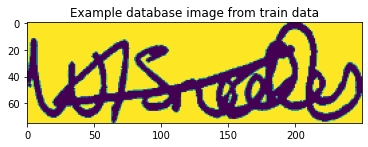

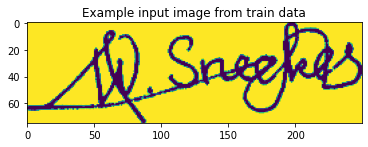

In [10]:
train_db_imgs, train_inp_imgs = load_eval_data(train_path, train_df)
print('train_db_imgs.shape =', train_db_imgs.shape)
print('train_inp_imgs.shape =', train_inp_imgs.shape)

plt.imshow(train_db_imgs[0].reshape(75, 250))
plt.title('Example database image from train data')
plt.show()
plt.imshow(train_inp_imgs[0].reshape(75, 250))
plt.title('Example input image from train data')
plt.show()

100%|██████████| 5748/5748 [00:40<00:00, 143.49it/s]


test_db_imgs.shape = (5748, 75, 250, 1)
test_inp_imgs.shape = (5748, 75, 250, 1)


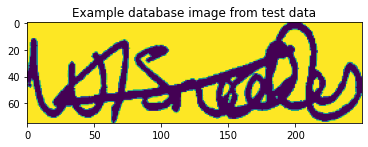

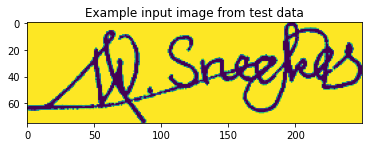

In [11]:
test_db_imgs, test_inp_imgs = load_eval_data(test_path, test_df)
print('test_db_imgs.shape =', test_db_imgs.shape)
print('test_inp_imgs.shape =', test_inp_imgs.shape)

plt.imshow(test_db_imgs[0].reshape(75, 250))
plt.title('Example database image from test data')
plt.show()
plt.imshow(test_inp_imgs[0].reshape(75, 250))
plt.title('Example input image from test data')
plt.show()

Download the trained model using wget

In [12]:
!wget -c https://www.dropbox.com/s/ym2uaypyorvrfbf/base_network_final.h5

--2021-01-20 18:17:35--  https://www.dropbox.com/s/ym2uaypyorvrfbf/base_network_final.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ym2uaypyorvrfbf/base_network_final.h5 [following]
--2021-01-20 18:17:35--  https://www.dropbox.com/s/raw/ym2uaypyorvrfbf/base_network_final.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc99eb11b87645918a4f4e32adbe.dl.dropboxusercontent.com/cd/0/inline/BHYqu_H8oIbe8XvzW0BT5o_lTrCU76mst6jXAg6WOtlLL6eQNDMrV-Ot1Z0aODK2r-fSCQFCJRgRjFNTpZLRkqwsH-3DjeZGbZYpdAGzeAs8JEVLlj1Nelrh-_NYuhEpGLc/file# [following]
--2021-01-20 18:17:36--  https://uc99eb11b87645918a4f4e32adbe.dl.dropboxusercontent.com/cd/0/inline/BHYqu_H8oIbe8XvzW0BT5o_lTrCU76mst6jXAg6WOtlLL6eQNDMrV-Ot1Z0aODK2r-fSCQFCJRgRjFNTp

In [13]:
model_path = '/content/base_network_final.h5'
base_network = tf.keras.models.load_model(model_path, compile=False)

In [14]:
def build_eval_model(threshold=400.0):
    '''
    Builds and returns the model that can be used for inference and evaluation
    '''
    input_1 = Input(shape=(75, 250, 1))
    input_2 = Input(shape=(75, 250, 1))

    output_1 = base_network(input_1)
    output_2 = base_network(input_2)

    squared_dist = Lambda(lambda x: tf.math.reduce_mean(tf.math.squared_difference(x[0], x[1]), axis=1))([output_1, output_2])

    pred = Lambda(lambda x: x >= threshold)(squared_dist)

    model = tf.keras.Model(inputs=[input_1, input_2], outputs=pred)

    return model

In [15]:
eval_model = build_eval_model()
eval_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 250, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75, 250, 1)] 0                                            
__________________________________________________________________________________________________
base_network (Sequential)       (None, 1024)         5814272     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None,)              0           base_network[0][0]           

Get predictions of train data from the model

In [16]:
y_pred_train = eval_model.predict([train_db_imgs, train_inp_imgs], verbose=1)
y_true_train = train_df['label'].values
assert y_pred_train.shape == y_true_train.shape, str(y_pred_train.shape) + " " + str(y_true_train.shape)

726/726 [==============================] - 20s 19ms/step


Get predictions of test data from the model

In [17]:
y_pred_test = eval_model.predict([test_db_imgs, test_inp_imgs], verbose=1)
y_true_test = test_df['label'].values
assert y_pred_test.shape == y_true_test.shape, str(y_pred_test.shape) + " " + str(y_true_test.shape)

180/180 [==============================] - 4s 20ms/step


In [18]:
print('Confusion matrix for train data:')
print(confusion_matrix(y_true_train, y_pred_train))

Confusion matrix for train data:
[[8858 3744]
 [1339 9265]]


In [19]:
print('Classification report for train data:')
print(classification_report(y_true_train, y_pred_train))

Classification report for train data:
              precision    recall  f1-score   support

           0       0.87      0.70      0.78     12602
           1       0.71      0.87      0.78     10604

    accuracy                           0.78     23206
   macro avg       0.79      0.79      0.78     23206
weighted avg       0.80      0.78      0.78     23206



In [20]:
print('Confusion matrix for test data:')
print(confusion_matrix(y_true_test, y_pred_test))

Confusion matrix for test data:
[[2090  682]
 [ 529 2447]]


In [21]:
print('Classification report for test data:')
print(classification_report(y_true_test, y_pred_test))

Classification report for test data:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      2772
           1       0.78      0.82      0.80      2976

    accuracy                           0.79      5748
   macro avg       0.79      0.79      0.79      5748
weighted avg       0.79      0.79      0.79      5748

